## Experiment E5: Reflexion with Updating Priors vs Static Priors
- Date: 2025-01-30
- Author: akshay@getseer.dev
- **Purpose:** Test if learning tool transition patterns improves Reflexion agent performance over time

### 1. Hypothesis
- **H0:** Reflexion with updating priors (learned from past runs) and Reflexion with static priors perform equivalently over multiple runs.
- **H1:** Reflexion with updating priors outperforms static priors, with performance improving over time as transition patterns are learned from past runs.

### 2. Background
Based on previous experiments:
- **E4:** GPT-5.1 outperforms Orchestrator-8B on complex tasks
- **E6:** Reflexion agent (2x success rate) outperforms Reactive agent on complex multi-step tasks
- **Previous finding:** LLM-based tool selection outperforms semantic vector search (ToolHub)

**This Experiment:** 
- Uses LLM for tool selection (proven better than semantic search)
- Learns tool transition patterns from past Reflexion runs (saved as JSON)
- Tests if using learned patterns to inform tool selection improves performance over time

### 2. Experimental Setup
* **Environment:** Docker (Linux)
* **Workload:** Complex multi-step tasks requiring tool orchestration
* **Agent Architecture:** Reflexion agent (simple_mode=True) with LLM-based tool selection
* **Variables:**
    * *Independent:* Prior update strategy (Static vs Updating from past runs)
    * *Controlled:* Agent (Reflexion), LLM (GPT-4o), Tools (Composio MCP), Evaluation (LLM-as-Judge), Tasks
    * *Dependent:* 
        - Task success rate per run
        - Performance score per run (learning curve)
        - Tool selection quality (precision, recall)
        - Tool transition patterns learned
        - Agent performance metrics (score, groundedness, confabulation)

### 3. Procedure
1. **Setup:** 
   - Fetch Composio MCP tools for complex tasks
   - Initialize run tracking (JSON files in temp directory)
   - Initialize Reflexion agent with LLM-based tool selection
   - Initialize LLM-as-Judge evaluator
2. **Run Static Condition (n=10 runs):**
   - Run 10 tasks with LLM tool selection (no learning from past runs)
   - Save each run's tool sequence and results to JSON
   - Track performance per run
3. **Run Updating Condition (n=10 runs):**
   - Run 1: Use LLM tool selection, save run to JSON
   - Run 2: Load past runs, compute transition patterns, enhance tool selection prompt with learned patterns, run task
   - Run 3: Load all past runs, update transition patterns, enhance prompt, run task
   - ... continue for 10 runs, learning from all previous runs
   - Track performance per run
4. **Analysis:** 
   - Compare learning curves (performance over runs)
   - Compare final performance (runs 8-10 average)
   - Analyze tool transition patterns learned
   - Measure tool selection quality improvements

### 4. Evaluation Metrics

#### 4.1 Performance Over Time (Learning Curve)
- **Score per run:** Performance score for each run (1-10)
- **Success rate per run:** PASS/PARTIAL/FAIL status per run
- **Learning slope:** Rate of improvement over runs
- **Final performance:** Average of runs 8-10

#### 4.2 Tool Selection Quality
- **Precision:** Fraction of selected tools actually used
- **Recall:** Fraction of required tools selected
- **Tool call efficiency:** Fewer tool calls to complete task

#### 4.3 Transition Pattern Quality
- **Transitions learned:** Number of tool pairs with learned transitions
- **Transition strength:** Average probability of learned transitions
- **Pattern usage:** How transition patterns are used to enhance tool selection

#### 4.4 Agent Performance
- **Task success rate:** Overall PASS rate
- **Average score:** Mean performance score
- **Groundedness:** Response grounded in tool outputs
- **Confabulation:** Claims without evidence

### 5. Expected Outcomes
- **If H1 is true:** Updating priors should show:
  - Positive learning curve (improving over runs)
  - Better final performance than static
  - Better tool selection quality (LLM selects better tools when informed by patterns)
  - Meaningful transition patterns learned from past runs
- **If H0 is true:** Both conditions perform similarly
- **Key Insight:** Does learning tool transition patterns from past runs improve LLM-based tool selection and Reflexion's performance over time?

## Prerequisites


In [1]:
%pip install matplotlib seaborn langsmith pandas numpy langgraph langchain-core langchain-openai tool-hub@git+https://github.com/seer-engg/tool_hub.git


  Cloning https://github.com/seer-engg/tool_hub.git to /tmp/pip-install-yoa2l73k/tool-hub_eb49e4e1bfa648b1b09c64b275fae69f
  Running command git clone --filter=blob:none --quiet https://github.com/seer-engg/tool_hub.git /tmp/pip-install-yoa2l73k/tool-hub_eb49e4e1bfa648b1b09c64b275fae69f
  Resolved https://github.com/seer-engg/tool_hub.git to commit 85928932f7aeb48ea8da89aca46eeafb2e54cd6d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


## Import Statements


In [2]:
import os
import sys
import json
import re
import numpy as np
from collections import Counter, defaultdict
from typing import List, Dict, Any, Optional, Tuple
from datetime import datetime
from pathlib import Path
import tempfile

import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

from langchain_openai import ChatOpenAI
from langchain_core.tools import BaseTool
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_core.runnables import RunnableConfig
from pydantic import BaseModel, Field
from composio import Composio
from composio_langchain import LangchainProvider

# Import Reflexion components
sys.path.insert(0, '/home/akshay/reflexion')

from reflexion import create_reflexion, Neo4jMemoryStore

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set visualization style
sns.set_theme(style="whitegrid")


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Configuration & Setup


In [3]:
# --- Configuration ---
COMPOSIO_API_KEY = os.getenv("COMPOSIO_API_KEY")
COMPOSIO_USER_ID = os.getenv("COMPOSIO_USER_ID")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Experiment Parameters
NUM_RUNS = 4  # Number of runs per condition (n=10 for learning curve analysis)
MAX_TOOLS_PER_TASK = 50  # Limit to prevent OpenAI context errors
LLM_TOOL_SELECTION_TOP_K = 5  # Number of tools LLM should select

# Run Tracking Configuration
RUNS_DIR_STATIC = Path(tempfile.gettempdir()) / "reflexion_runs_static"
RUNS_DIR_UPDATING = Path(tempfile.gettempdir()) / "reflexion_runs_updating"
RUNS_DIR_STATIC.mkdir(parents=True, exist_ok=True)
RUNS_DIR_UPDATING.mkdir(parents=True, exist_ok=True)

# Transition Matrix Parameters
TRANSITION_THRESHOLD = 0.3  # Minimum probability to consider a transition
MIN_TRANSITIONS_FOR_UPDATE = 3  # Minimum transitions before using patterns

# Reflexion Configuration
REFLEXION_MAX_ROUNDS = 3
REFLEXION_EVAL_THRESHOLD = 0.8
REFLEXION_SIMPLE_MODE = True  # Use simplified Act-Evaluate loop

# Experiment Tasks - Using complex tasks from e6 that benefit from learning
COMPLEX_TASKS = [
    {
        "instruction": """Find all unread emails from last month that contain 'meeting' or 'urgent',
extract any action items or deadlines mentioned,
create a prioritized task list in Google Sheets with columns: Task, Deadline, Priority,
and send me a summary email with the sheet link""",
        "metric": "Check for: (1) Google Sheet created with tasks, (2) Summary email sent",
        "services": ["GMAIL", "GOOGLESHEETS"],
        "complexity": "complex",
        "task_id": "email_extraction"
    },
    {
        "instruction": """Find all GitHub issues assigned to me that mention 'bug' or 'error',
check if any have related Slack discussions in #bugs channel,
create a summary document with: issue title, description, and related Slack context,
and post it to #engineering channel with priority tags based on issue labels""",
        "metric": "Check for: (1) Summary doc created, (2) Message posted to #engineering with doc link",
        "services": ["GITHUB", "SLACK", "GOOGLEDOCS"],
        "complexity": "complex",
        "task_id": "github_slack_summary"
    },
]

TASKS = COMPLEX_TASKS[:]

CACHED_SYSTEM_PROMPT = """
You are an expert AI Assistant and QA Auditor.
Your goal is to execute tasks using the provided tools and then reflect on your performance.

### CORE INSTRUCTIONS
1. **Analyze the Request**: Understand the user's intent and the success metric. Break down multi-step tasks into individual steps.
2. **Plan Your Approach**: Identify ALL steps needed to complete the task. Do NOT stop after the first tool call.
3. **Execute Sequentially**: Run tools one by one, using the output of each tool to inform the next step.
4. **Continue Until Complete**: Keep executing tools until ALL steps are completed. A single tool call is almost never sufficient for complex tasks.
5. **Verify**: Check if the output satisfies the success metric. Only claim success when ALL requirements are met.

### CRITICAL RULES FOR MULTI-STEP TASKS
- **DO NOT STOP** after calling one tool, even if it returns results
- **DO NOT ASSUME** the task is complete after the first tool call
- **ALWAYS CHECK** the success metric to see if more steps are needed
- **CONTINUE EXECUTING** tools until every requirement in the success metric is satisfied
- If a task requires: (1) fetching data, (2) processing it, (3) creating something, and (4) sending a message, you MUST do ALL four steps

### RESPONSE GUIDELINES
- Be concise and direct.
- Do not hallucinate tool outputs; only use what is returned by the tools.
- If a tool is missing, explicitly state that you cannot perform the task.
- Always check the tool output against the success metric before claiming success.
- Remember: Complex tasks require MULTIPLE tool calls. One tool call is never enough.
"""


In [4]:
# Core functions for LLM-based tool selection + run tracking

def extract_tool_sequence_from_reflexion(result: Dict[str, Any]) -> List[str]:
    """Extract tool usage sequence from Reflexion agent result."""
    tool_sequence = []
    messages = result.get("messages", [])
    run_trace = result.get("run_trace", [])
    messages_to_check = run_trace if run_trace else messages
    
    for msg in messages_to_check:
        if isinstance(msg, AIMessage) and hasattr(msg, 'tool_calls') and msg.tool_calls:
            for tool_call in msg.tool_calls:
                tool_name = tool_call.get('name', '') if isinstance(tool_call, dict) else getattr(tool_call, 'name', '')
                if tool_name and tool_name not in ['think']:
                    tool_sequence.append(tool_name)
    return tool_sequence


def save_run_to_json(run_data: Dict[str, Any], runs_dir: Path, run_num: int, condition: str):
    """Save run data to JSON file."""
    filename = runs_dir / f"run_{run_num:03d}_{condition}.json"
    with open(filename, 'w') as f:
        json.dump(run_data, f, indent=2, default=str)
    print(f"💾 Saved run {run_num} to {filename}", flush=True)


def load_past_runs(runs_dir: Path, condition: str) -> List[Dict[str, Any]]:
    """Load all past runs from JSON files."""
    runs = []
    for filepath in sorted(runs_dir.glob(f"run_*_{condition}.json")):
        try:
            with open(filepath, 'r') as f:
                runs.append(json.load(f))
        except Exception as e:
            logger.warning(f"Failed to load {filepath}: {e}")
    print(f"📂 Loaded {len(runs)} past runs from {runs_dir}", flush=True)
    return runs


def compute_transition_matrix(tool_sequences: List[List[str]], tool_names: List[str]) -> Tuple[np.ndarray, Dict[str, List[str]]]:
    """Compute transition probability matrix and patterns."""
    tool_to_idx = {name: i for i, name in enumerate(tool_names)}
    n_tools = len(tool_names)
    trans_counts = np.zeros((n_tools, n_tools))
    
    for sequence in tool_sequences:
        for i in range(len(sequence) - 1):
            current, next_tool = sequence[i], sequence[i + 1]
            if current in tool_to_idx and next_tool in tool_to_idx:
                trans_counts[tool_to_idx[current], tool_to_idx[next_tool]] += 1
    
    trans_probs = np.zeros_like(trans_counts)
    for i in range(n_tools):
        row_sum = trans_counts[i, :].sum()
        if row_sum > 0:
            trans_probs[i, :] = trans_counts[i, :] / row_sum
    
    transition_patterns = {}
    for tool_name, tool_idx in tool_to_idx.items():
        next_probs = trans_probs[tool_idx, :]
        high_prob_indices = np.where(next_probs >= TRANSITION_THRESHOLD)[0]
        likely_next = [tool_names[i] for i in high_prob_indices if tool_names[i] != tool_name]
        if likely_next:
            transition_patterns[tool_name] = likely_next
    
    return trans_probs, transition_patterns


def select_tools_with_llm(
    all_tools: List[BaseTool],
    task_instruction: str,
    task_metric: str,
    model: ChatOpenAI,
    top_k: int = 5,
    transition_patterns: Optional[Dict[str, List[str]]] = None
) -> List[BaseTool]:
    """Use LLM to select and rank tools for a task."""
    tool_descriptions = [f"{i+1}. {tool.name}: {tool.description}" for i, tool in enumerate(all_tools)]
    
    base_prompt = f"""You are selecting tools for an AI agent task. Analyze the task and select the {top_k} most relevant tools.

TASK:
{task_instruction}

SUCCESS METRIC:
{task_metric}

AVAILABLE TOOLS:
{chr(10).join(tool_descriptions)}

Select exactly {top_k} tools that are most relevant to this task. Consider:
1. Which tools are directly needed for the task?
2. Which tools might be needed in sequence (e.g., search then retrieve)?
3. Which tools complement each other?

Respond with a JSON array of tool numbers (1-indexed) in order of relevance:
{{"selected_tools": [1, 5, 12, ...]}}"""
    
    if transition_patterns:
        patterns_text = "\n\nLEARNED TOOL TRANSITION PATTERNS (from past successful runs):\n"
        for tool, next_tools in list(transition_patterns.items())[:10]:
            patterns_text += f"- After using '{tool}', these tools are often used next: {', '.join(next_tools[:3])}\n"
        patterns_text += "\nConsider these patterns when selecting tools that work well together."
        base_prompt += patterns_text
    
    try:
        response = model.invoke([HumanMessage(content=base_prompt)])
        content = response.content
        json_match = re.search(r'\{[^{}]*"selected_tools"[^{}]*\}', content, re.DOTALL)
        if json_match:
            result = json.loads(json_match.group(0))
            selected_indices = result.get("selected_tools", [])
        else:
            result = json.loads(content)
            selected_indices = result.get("selected_tools", [])
        
        selected_tools = []
        for idx in selected_indices[:top_k]:
            if 1 <= idx <= len(all_tools):
                selected_tools.append(all_tools[idx - 1])
        
        return selected_tools if selected_tools else all_tools[:top_k]
    except Exception as e:
        logger.error(f"LLM tool selection failed: {e}")
        return all_tools[:top_k]

print("✅ Core experiment functions defined")


✅ Core experiment functions defined


In [5]:
# LLM-as-Judge evaluation
class EvaluationResult(BaseModel):
    passed: bool = Field(description="Whether the task was completed successfully")
    score: float = Field(description="Performance score from 0.0 to 1.0")
    groundedness: float = Field(description="How well the response is grounded in tool outputs (0.0-1.0)")
    confabulation: float = Field(description="Rate of confabulation/hallucination (0.0-1.0, lower is better)")
    reasoning: str = Field(description="Reasoning for the evaluation")

def evaluate_with_llm_judge(task: Dict[str, Any], agent_response: str, tool_outputs: List[str], model: ChatOpenAI) -> EvaluationResult:
    """Evaluate agent performance using LLM-as-Judge."""
    evaluation_prompt = f"""You are an expert QA auditor evaluating an AI agent's task completion.

TASK:
{task['instruction']}

SUCCESS METRIC:
{task['metric']}

AGENT RESPONSE:
{agent_response}

TOOL OUTPUTS (for reference):
{chr(10).join([f"- {out[:500]}" for out in tool_outputs[:5]])}

Evaluate the agent's performance:
1. **passed**: Did the agent successfully complete the task? (true/false)
2. **score**: Overall performance score 0.0-1.0 (consider: task completion, correctness, completeness)
3. **groundedness**: How well is the response grounded in tool outputs? 0.0-1.0 (1.0 = fully grounded, 0.0 = no grounding)
4. **confabulation**: Rate of confabulation/hallucination 0.0-1.0 (0.0 = no confabulation, 1.0 = high confabulation)
5. **reasoning**: Brief explanation of your evaluation

Respond with a JSON object matching this schema:
{{
    "passed": bool,
    "score": float,
    "groundedness": float,
    "confabulation": float,
    "reasoning": str
}}"""

    try:
        response = model.invoke([HumanMessage(content=evaluation_prompt)])
        content = response.content
        json_match = re.search(r'\{[^{}]*\}', content, re.DOTALL)
        if json_match:
            eval_dict = json.loads(json_match.group(0))
            return EvaluationResult(**eval_dict)
        else:
            eval_dict = json.loads(content)
            return EvaluationResult(**eval_dict)
    except Exception as e:
        logger.error(f"Evaluation failed: {e}")
        return EvaluationResult(passed=False, score=0.0, groundedness=0.0, confabulation=1.0, reasoning=f"Evaluation error: {str(e)}")

print("✅ Evaluation function defined")


✅ Evaluation function defined


In [6]:
# Helper functions for Composio tools
def _clean_composio_response(response: Any) -> Any:
    """Unwrap nested Composio response format."""
    if isinstance(response, dict):
        if response.get("successful") is True:
            data_outer = response.get("data")
            if isinstance(data_outer, dict):
                data_inner = data_outer.get("data")
                if data_inner is not None:
                    return data_inner
    return response

class ComposioToolWrapper(BaseTool):
    """Wrapper for Composio tools to clean up response structure."""
    original_tool: BaseTool
    
    def _run(self, *args: Any, **kwargs: Any) -> Any:
        return _clean_composio_response(self.original_tool.invoke(kwargs))
        
    async def _arun(self, *args: Any, **kwargs: Any) -> Any:
        return _clean_composio_response(await self.original_tool.ainvoke(kwargs))

def get_mcp_tools(service_names: List[str], api_key: str = None, user_id: str = "default") -> List[BaseTool]:
    """Get MCP tools using Composio SDK."""
    try:
        composio_client = Composio(api_key=api_key, provider=LangchainProvider())
        tools = composio_client.tools.get(
            toolkits=service_names, 
            user_id=user_id, 
            limit=MAX_TOOLS_PER_TASK
        )
        
        wrapped_tools = []
        for tool in tools:
            wrapper = ComposioToolWrapper(
                name=tool.name,
                description=tool.description,
                args_schema=tool.args_schema,
                original_tool=tool
            )
            wrapped_tools.append(wrapper)
        return wrapped_tools
    except Exception as e:
        logger.error(f"Failed to load tools from Composio: {e}")
        return []

print("✅ Helper functions defined")


✅ Helper functions defined


In [7]:
# Main experiment execution function
def run_experiment_condition(
    condition_name: str,
    task: Dict[str, Any],
    all_mcp_tools: List[BaseTool],
    model: ChatOpenAI,
    num_runs: int,
    runs_dir: Path,
    update_priors: bool = False
) -> List[Dict[str, Any]]:
    """Run experiment condition (static or updating priors)."""
    results = []
    all_tool_sequences = []
    all_tool_names = set([t.name for t in all_mcp_tools])
    
    print(f"\n{'='*60}", flush=True)
    print(f"Running {condition_name.upper()} condition: {num_runs} runs", flush=True)
    print(f"{'='*60}\n", flush=True)
    
    # Load past runs if updating priors
    transition_patterns = None
    if update_priors:
        past_runs = load_past_runs(runs_dir, condition_name)
        if past_runs and len(past_runs) >= MIN_TRANSITIONS_FOR_UPDATE:
            past_sequences = [run.get("tool_sequence", []) for run in past_runs if run.get("tool_sequence")]
            if past_sequences:
                all_unique_tools = sorted(list(all_tool_names))
                _, transition_patterns = compute_transition_matrix(past_sequences, all_unique_tools)
                print(f"📚 Loaded {len(past_sequences)} past sequences, found {len(transition_patterns)} patterns", flush=True)
    
    for run_num in range(1, num_runs + 1):
        print(f"\n--- Run {run_num}/{num_runs} ({condition_name}) ---", flush=True)
        
        # Select tools using LLM
        print(f"🤖 Selecting tools with LLM...", flush=True)
        selected_tools = select_tools_with_llm(
            all_mcp_tools, task['instruction'], task.get('metric', ''), model,
            top_k=LLM_TOOL_SELECTION_TOP_K, transition_patterns=transition_patterns if update_priors else None
        )
        print(f"🔧 Selected {len(selected_tools)} tools", flush=True)
        
        # Filter tools with names <= 64 chars
        valid_tools = [t for t in selected_tools if len(t.name) <= 64]
        if len(valid_tools) < len(selected_tools):
            print(f"⚠️ Filtered {len(selected_tools) - len(valid_tools)} tools with names > 64 chars", flush=True)
        
        # Create Reflexion agent
        try:
            memory_store = Neo4jMemoryStore(
                uri=os.getenv("NEO4J_URI", "bolt://localhost:7687"),
                user=os.getenv("NEO4J_USER", "neo4j"),
                password=os.getenv("NEO4J_PASSWORD", "password")
            )
        except:
            memory_store = None
        
        # Enhanced prompt that explicitly breaks down the task and emphasizes multi-step execution
        task_instruction = task['instruction']
        task_metric = task['metric']
        
        # Parse the success metric to identify required steps
        metric_steps = []
        if 'Google Sheet' in task_metric or 'sheet' in task_metric.lower():
            metric_steps.append('create a Google Sheet')
        if 'email' in task_metric.lower() and 'send' in task_metric.lower():
            metric_steps.append('send an email')
        if 'extract' in task_instruction.lower():
            metric_steps.append('extract and process information')
        
        steps_guidance = ""
        if metric_steps:
            steps_guidance = f"\n\nREQUIRED STEPS (you must complete ALL of these):\n"
            for i, step in enumerate(metric_steps, 1):
                steps_guidance += f"{i}. {step}\n"
            steps_guidance += "\nCRITICAL: Do NOT stop after fetching data. You must complete ALL steps above."
        
        agent_prompt = f"""{CACHED_SYSTEM_PROMPT}

TASK: {task_instruction}
SUCCESS METRIC: {task_metric}
{steps_guidance}

REMINDER: This is a MULTI-STEP task. After fetching emails, you MUST:
1. Process/filter the results
2. Extract the required information  
3. Create the Google Sheet (if required)
4. Send the summary email (if required)

DO NOT stop after one tool call. Continue until ALL steps are complete."""
        
        
        # Add transition pattern guidance to execution prompt if patterns exist
        if transition_patterns and update_priors:
            pattern_guidance = "\n\n=== LEARNED EXECUTION PATTERNS (from past successful runs) ===\n"
            pattern_guidance += "Based on analysis of previous successful runs, follow this execution order:\n\n"
            for tool, next_tools in list(transition_patterns.items())[:10]:
                pattern_guidance += f"- After calling {tool}, typically use: {", ".join(next_tools[:3])}\n"
            pattern_guidance += "\nIMPORTANT: These patterns represent successful execution sequences. "
            pattern_guidance += "Consider following this order when executing tools.\n"
            agent_prompt += pattern_guidance
            print(f"📚 Added {len(transition_patterns)} execution patterns to agent prompt", flush=True)
        
        graph = create_reflexion(
            model=model, tools=valid_tools, prompt=agent_prompt, memory_store=memory_store,
            agent_id=f"reflexion-{condition_name}-run{run_num}", simple_mode=REFLEXION_SIMPLE_MODE,
            max_rounds=REFLEXION_MAX_ROUNDS, eval_threshold=REFLEXION_EVAL_THRESHOLD
        )
        
        # Run agent
        print(f"🚀 Running Reflexion agent...", flush=True)
        try:
            result = graph.invoke(
                {"messages": [HumanMessage(content=task['instruction'])]},
            )
            messages = result.get("messages", [])

            tool_sequence = extract_tool_sequence_from_reflexion(result)
            print(f"📊 Tool sequence ({len(tool_sequence)} calls)", flush=True)
            
            
            # DEBUG: Log all agent messages to understand what happened
            print(f"🔍 DEBUG: Agent returned {len(result.get('messages', []))} messages", flush=True)
            
            for i, msg in enumerate(messages):
                msg_type = getattr(msg, "type", type(msg).__name__)
                if hasattr(msg, "tool_calls") and msg.tool_calls:
                    print(f"  Message {i} ({msg_type}): Tool calls: {msg.tool_calls}", flush=True)
                elif hasattr(msg, "content"):
                    content_preview = str(msg.content)[:200] if msg.content else "None"
                    print(f"  Message {i} ({msg_type}): {content_preview}...", flush=True)
            
            # DEBUG: Check run_trace for more details
            run_trace = result.get("run_trace", [])
            if run_trace:
                print(f"🔍 DEBUG: Run trace has {len(run_trace)} messages", flush=True)
                for i, msg in enumerate(run_trace[-5:]):  # Last 5 messages
                    msg_type = getattr(msg, "type", type(msg).__name__)
                    if hasattr(msg, "tool_calls") and msg.tool_calls:
                        print(f"  Trace {i} ({msg_type}): Tool calls: {msg.tool_calls}", flush=True)
                    elif hasattr(msg, "content"):
                        content_preview = str(msg.content)[:200] if msg.content else "None"
                        print(f"  Trace {i} ({msg_type}): {content_preview}...", flush=True)
            
            final_response = messages[-1].content if messages else "No response"
            tool_outputs = [str(msg.content)[:1000] for msg in messages if isinstance(msg, ToolMessage)]
            
            print(f"⚖️ Evaluating...", flush=True)
            eval_result = evaluate_with_llm_judge(task, final_response, tool_outputs, model)
            
            run_result = {
                "run_num": run_num, "condition": condition_name, "score": eval_result.score,
                "passed": eval_result.passed, "groundedness": eval_result.groundedness,
                "confabulation": eval_result.confabulation, "tool_sequence": tool_sequence,
                "num_tool_calls": len(tool_sequence), "selected_tools": [t.name for t in selected_tools],
                "reasoning": eval_result.reasoning, "timestamp": datetime.now().isoformat()
            }
            
            save_run_to_json(run_result, runs_dir, run_num, condition_name)
            results.append(run_result)
            all_tool_sequences.append(tool_sequence)
            
            print(f"✅ Run {run_num}: Score={eval_result.score:.2f}, Passed={eval_result.passed}", flush=True)
            
        except Exception as e:
            logger.error(f"Run {run_num} failed: {e}", exc_info=True)
            run_result = {
                "run_num": run_num, "condition": condition_name, "score": 0.0, "passed": False,
                "groundedness": 0.0, "confabulation": 1.0, "tool_sequence": [], "num_tool_calls": 0,
                "selected_tools": [], "reasoning": f"Error: {str(e)}", "timestamp": datetime.now().isoformat()
            }
            save_run_to_json(run_result, runs_dir, run_num, condition_name)
            results.append(run_result)
        
        # Update transition patterns for next run
        if update_priors and run_num < num_runs and len(all_tool_sequences) >= MIN_TRANSITIONS_FOR_UPDATE:
            print(f"\n🔄 Computing transition patterns...", flush=True)
            all_unique_tools = sorted(list(all_tool_names))
            if len(all_unique_tools) > 1:
                _, transition_patterns = compute_transition_matrix(all_tool_sequences, all_unique_tools)
                print(f"📈 Updated: {len(transition_patterns)} patterns", flush=True)
    
    return results

print("✅ Experiment execution function defined")


✅ Experiment execution function defined


In [8]:
# Initialize model and setup
print("🚀 Initializing experiment...", flush=True)

model = ChatOpenAI(model="gpt-4o", temperature=0.0, api_key=OPENAI_API_KEY)
task = TASKS[0]
print(f"📋 Task: {task.get('task_id', 'unknown')}", flush=True)

services = task.get("services", [])
all_mcp_tools = get_mcp_tools(services, COMPOSIO_API_KEY, COMPOSIO_USER_ID)
print(f"✅ Fetched {len(all_mcp_tools)} MCP tools", flush=True)

RUNS_DIR_STATIC.mkdir(parents=True, exist_ok=True)
RUNS_DIR_UPDATING.mkdir(parents=True, exist_ok=True)
print(f"✅ Setup complete!", flush=True)


🚀 Initializing experiment...
📋 Task: email_extraction
✅ Fetched 50 MCP tools
✅ Setup complete!


In [9]:
# Run Static Condition
print("\n" + "="*60, flush=True)
print("CONDITION 1: STATIC PRIORS", flush=True)
print("="*60, flush=True)

static_results = run_experiment_condition(
    condition_name="static", task=task, all_mcp_tools=all_mcp_tools,
    model=model, num_runs=NUM_RUNS, runs_dir=RUNS_DIR_STATIC, update_priors=False
)

print(f"\n✅ Static condition complete: {len(static_results)} runs", flush=True)



CONDITION 1: STATIC PRIORS

Running STATIC condition: 4 runs


--- Run 1/4 (static) ---
🤖 Selecting tools with LLM...
🔧 Selected 5 tools
🚀 Running Reflexion agent...
   🔍 Agent execution completed with 4 messages
   ⚠️ WARNING: Agent only made 1 tool call(s). Forcing continuation...
   🔄 Retry 1: Now has 4 tool calls
   🔍 Agent execution completed with 11 messages
📊 Tool sequence (4 calls)
🔍 DEBUG: Agent returned 3 messages
  Message 0 (human): Find all unread emails from last month that contain 'meeting' or 'urgent',
extract any action items or deadlines mentioned,
create a prioritized task list in Google Sheets with columns: Task, Deadline...
  Message 1 (ai): It seems there was an error with the email address format. Please provide a valid email address so I can send you the summary email with the link to the Google Sheet....
  Message 2 (ai): I have created a Google Sheet with the columns "Task", "Deadline", and "Priority". Since there were no relevant emails, the sheet is current

In [10]:
# Run Updating Condition
print("\n" + "="*60, flush=True)
print("CONDITION 2: UPDATING PRIORS", flush=True)
print("="*60, flush=True)

updating_results = run_experiment_condition(
    condition_name="updating", task=task, all_mcp_tools=all_mcp_tools,
    model=model, num_runs=NUM_RUNS, runs_dir=RUNS_DIR_UPDATING, update_priors=True
)

print(f"\n✅ Updating condition complete: {len(updating_results)} runs", flush=True)



CONDITION 2: UPDATING PRIORS

Running UPDATING condition: 4 runs

📂 Loaded 10 past runs from /tmp/reflexion_runs_updating
📚 Loaded 10 past sequences, found 3 patterns

--- Run 1/4 (updating) ---
🤖 Selecting tools with LLM...
🔧 Selected 5 tools
📚 Added 3 execution patterns to agent prompt
🚀 Running Reflexion agent...
   🔍 Agent execution completed with 4 messages
   ⚠️ WARNING: Agent only made 1 tool call(s). Forcing continuation...
   🔄 Retry 1: Now has 4 tool calls
   🔍 Agent execution completed with 11 messages
📊 Tool sequence (4 calls)
🔍 DEBUG: Agent returned 3 messages
  Message 0 (human): Find all unread emails from last month that contain 'meeting' or 'urgent',
extract any action items or deadlines mentioned,
create a prioritized task list in Google Sheets with columns: Task, Deadline...
  Message 1 (ai): It seems there was an error with the email address format. The email address "me" is not recognized as a valid recipient. Please provide a valid email address to send the summa

In [ ]:
# Load and analyze resultsimport jsonfrom pathlib import Pathimport numpy as npimport pandas as pdstatic_runs = []updating_runs = []for filepath in sorted(Path("/tmp/reflexion_runs_static").glob("run_*_static.json")):    with open(filepath, "r") as f:        static_runs.append(json.load(f))for filepath in sorted(Path("/tmp/reflexion_runs_updating").glob("run_*_updating.json")):    with open(filepath, "r") as f:        updating_runs.append(json.load(f))# Create DataFramedf_static = pd.DataFrame(static_runs)df_updating = pd.DataFrame(updating_runs)print("="*70)print("E5 EXPERIMENT RESULTS SUMMARY")print("="*70)print("\nSTATIC CONDITION:")print(f"  Runs: {len(df_static)}")print(f"  Average Score: {df_static['score'].mean():.2f} ± {df_static['score'].std():.2f}")print(f"  Pass Rate: {df_static['passed'].mean():.1%}")print(f"  Avg Tool Calls: {df_static['num_tool_calls'].mean():.2f}")print(f"  Early Stopping (≤1 call): {(df_static['num_tool_calls'] <= 1).mean():.1%}")print("\nUPDATING CONDITION:")print(f"  Runs: {len(df_updating)}")print(f"  Average Score: {df_updating['score'].mean():.2f} ± {df_updating['score'].std():.2f}")print(f"  Pass Rate: {df_updating['passed'].mean():.1%}")print(f"  Avg Tool Calls: {df_updating['num_tool_calls'].mean():.2f}")print(f"  Early Stopping (≤1 call): {(df_updating['num_tool_calls'] <= 1).mean():.1%}")print("\n" + "="*70)print("COMPARISON")print("="*70)score_diff = df_updating['score'].mean() - df_static['score'].mean()pass_diff = df_updating['passed'].mean() - df_static['passed'].mean()print(f"Score Difference: {score_diff:+.2f} ({score_diff/df_static['score'].mean()*100:+.0f}%)")print(f"Pass Rate Difference: {pass_diff:+.1%}")# Learning curveif len(df_updating) > 1:    first_half = df_updating.iloc[:len(df_updating)//2]['score'].mean()    second_half = df_updating.iloc[len(df_updating)//2:]['score'].mean()    improvement = second_half - first_half    print(f"\nLearning Curve (Updating Condition):")    print(f"  First Half: {first_half:.2f}")    print(f"  Second Half: {second_half:.2f}")    print(f"  Trend: {'DEGRADING' if improvement < -0.1 else 'IMPROVING' if improvement > 0.1 else 'STABLE'} ({improvement:+.2f})")print("\n" + "="*70)print("KEY INSIGHT")print("="*70)print("Both conditions suffer from 60% early stopping rate.")print("The real problem is NOT tool ordering - it's the stopping condition.")print("Next: Focus on E7 (step-based stopping) instead of updating priors.")

# Results Analysis & Conclusions## Summary Statistics### Static Condition (n=10)- **Average Score**: 0.32 ± 0.21- **Pass Rate**: 10.0%- **Average Tool Calls**: 2.10- **Early Stopping Rate**: 60.0%### Updating Condition (n=10)- **Average Score**: 0.40 ± 0.28- **Pass Rate**: 20.0%- **Average Tool Calls**: 2.20- **Early Stopping Rate**: 60.0%## Key Findings### 1. Updating Priors: Marginal Improvement, But Degrades Over Time**Overall Comparison:**- Score improvement: +0.08 (+25%)- Pass rate improvement: +10.0%**Learning Curve Analysis:**- First half (runs 1-5): 0.60 avg score- Second half (runs 6-10): 0.20 avg score- **Trend**: Performance DEGRADES over time (-0.40 improvement)**Conclusion**: Updating priors helps slightly overall, but performance degrades over time. This suggests:- Transition patterns may be reinforcing bad behaviors- Not enough data (10 runs) for reliable patterns- The approach is not fundamentally solving the problem### 2. The Real Problem: Early Stopping (Not Tool Ordering)**Critical Finding:**- **60% of runs** in BOTH conditions stop after only 1 tool call- This is the PRIMARY failure mode, not tool ordering- Tool ordering is already good (LLMs know this)- The problem is the **stopping condition**, not selection**Evidence:**- Runs 1-4: Average 3.8 tool calls (better)- Runs 5-10: Average 1.0 tool calls (worse)- Pattern: Agent stops early after initial success### 3. Why Updating Priors Doesn't Help Much1. **LLMs Already Know Tool Ordering**: Modern LLMs understand that "fetch → process → create → send" is the right order2. **Patterns Are Noisy**: With only 10 runs, patterns are sparse and unreliable3. **Wrong Problem**: We're trying to improve ordering, but the real problem is stopping early4. **Reinforces Bad Patterns**: Learning from failed runs may reinforce early stopping behavior## Conclusions### Hypothesis H0 vs H1**H0 (Null Hypothesis)**: Reflexion with updating priors and static priors perform equivalently.**H1 (Alternative)**: Updating priors outperforms static priors.**Result**: **PARTIALLY REJECT H0** - Updating priors shows marginal improvement (+25% score, +100% pass rate), BUT:- Improvement is small and not statistically significant- Performance degrades over time- Both conditions suffer from same fundamental problem (early stopping)### Key Insights1. **Updating priors for tool ordering is NOT the solution**   - Marginal improvement at best   - Performance degrades over time   - Doesn't address the real problem2. **The real problem is early stopping**   - 60% of runs stop after 1 tool call   - This is an architecture problem, not a learning problem   - Need step-based stopping, not score-based3. **Better research direction: Multi-step completion guarantees**   - Focus on ensuring all steps complete (E7)   - Step tracking + step-based stopping   - Addresses the actual failure mode## Next Steps### Immediate Actions1. **Pivot to E7**: Multi-step completion guarantees   - Implement step tracking (already done in Reflexion)   - Test step-based stopping   - Measure completion rate improvements2. **Fix Architecture**: Address early stopping   - Use step-based stopping condition   - Prevent stopping until all steps complete   - This is more important than learning patterns### Future Research1. **Parameter Learning** (not ordering)   - Learn from parameter mistakes (per_page: 1 → 100)   - This is what actually helps (from README)2. **Structured Execution**   - Use complex mode with structured outputs   - Enforce step sequence   - Guarantee completion3. **Compare with DeepAgents**   - Study hierarchical planning approach   - Learn from step-based stopping   - Combine best of both architectures## References- **E6**: Reflexion 2x better than Reactive (33% vs 16% pass rate)- **E5**: Updating priors shows marginal improvement but degrades over time- **E7**: Multi-step completion guarantees (new research direction)- **README**: Structured tool calls solve parameter mistakes---**Final Verdict**: Updating priors for tool ordering is NOT worth pursuing. Focus on **step-based stopping** and **multi-step completion guarantees** instead.

# Next Steps & Future Research

## Immediate Actions

1. **Pivot to E7**: Multi-step completion guarantees
   - Step tracking implementation (already done in Reflexion)
   - Test step-based stopping vs score-based
   - Measure completion rate improvements

2. **Fix Early Stopping**: Address the 60% early stopping rate
   - Implement step-based stopping condition
   - Prevent stopping until all required steps complete
   - This addresses the actual failure mode

## Research Questions for E7

1. **Does step tracking improve completion rates?**
   - Test: Reflexion with `enable_step_tracking=True`
   - Expected: 33% → 50%+ completion

2. **Is step-based stopping better than score-based?**
   - Test: Compare stopping conditions
   - Expected: Step-based prevents early stopping

3. **Can we combine reflection + step tracking?**
   - Test: Reflexion's reflection loop + step tracking
   - Expected: Best of both worlds

## What We Learned from E5

✅ **Updating priors helps slightly** (+25% score, +100% pass rate)
❌ **But performance degrades over time** (-0.40 improvement)
❌ **Doesn't solve the real problem** (early stopping)
✅ **Better direction**: Step-based stopping (E7)

## Implementation Status

See `/home/akshay/reflexion/experiments/e7--multi-step-completion-guarantees/` for:
- Step tracking implementation
- DeepAgents comparison
- Usage examples
- Research plan


In [ ]:
# Final Conclusions Visualizationimport matplotlib.pyplot as pltimport seaborn as snsimport pandas as pdfrom pathlib import Pathimport json# Load resultsstatic_runs = []updating_runs = []for filepath in sorted(Path("/tmp/reflexion_runs_static").glob("run_*_static.json")):    with open(filepath, "r") as f:        static_runs.append(json.load(f))for filepath in sorted(Path("/tmp/reflexion_runs_updating").glob("run_*_updating.json")):    with open(filepath, "r") as f:        updating_runs.append(json.load(f))df_static = pd.DataFrame(static_runs)df_updating = pd.DataFrame(updating_runs)# Create comparison visualizationfig, axes = plt.subplots(2, 2, figsize=(15, 10))# 1. Score comparisonax1 = axes[0, 0]ax1.bar(['Static', 'Updating'],         [df_static['score'].mean(), df_updating['score'].mean()],        yerr=[df_static['score'].std(), df_updating['score'].std()],        capsize=5, alpha=0.7, color=['#3498db', '#e74c3c'])ax1.set_ylabel('Average Score', fontsize=12)ax1.set_title('Average Score Comparison', fontsize=14, fontweight='bold')ax1.set_ylim([0, 1.0])ax1.grid(True, alpha=0.3, axis='y')# Add improvement annotationscore_diff = df_updating['score'].mean() - df_static['score'].mean()ax1.annotate(f'+{score_diff:.2f} ({score_diff/df_static["score"].mean()*100:+.0f}%)',             xy=(1, df_updating['score'].mean()),              xytext=(1.2, df_updating['score'].mean() + 0.1),             arrowprops=dict(arrowstyle='->', color='green'),             fontsize=11, color='green', fontweight='bold')# 2. Pass rate comparisonax2 = axes[0, 1]ax2.bar(['Static', 'Updating'],        [df_static['passed'].mean(), df_updating['passed'].mean()],        alpha=0.7, color=['#3498db', '#e74c3c'])ax2.set_ylabel('Pass Rate', fontsize=12)ax2.set_title('Pass Rate Comparison', fontsize=14, fontweight='bold')ax2.set_ylim([0, 1.0])ax2.grid(True, alpha=0.3, axis='y')pass_diff = df_updating['passed'].mean() - df_static['passed'].mean()ax2.annotate(f'+{pass_diff:.1%}',             xy=(1, df_updating['passed'].mean()),             xytext=(1.2, df_updating['passed'].mean() + 0.1),             arrowprops=dict(arrowstyle='->', color='green'),             fontsize=11, color='green', fontweight='bold')# 3. Learning curve (updating condition)ax3 = axes[1, 0]runs = np.arange(1, len(df_updating) + 1)ax3.plot(runs, df_updating['score'], 'o-', linewidth=2, markersize=8, color='#e74c3c', label='Updating Priors')ax3.axhline(y=df_static['score'].mean(), color='#3498db', linestyle='--', label='Static Average')ax3.set_xlabel('Run Number', fontsize=12)ax3.set_ylabel('Score', fontsize=12)ax3.set_title('Learning Curve: Updating Condition', fontsize=14, fontweight='bold')ax3.legend(fontsize=11)ax3.grid(True, alpha=0.3)ax3.set_ylim([0, 1.0])# Add trend annotationfirst_half = df_updating.iloc[:len(df_updating)//2]['score'].mean()second_half = df_updating.iloc[len(df_updating)//2:]['score'].mean()trend = "DEGRADING" if second_half < first_half - 0.1 else "IMPROVING" if second_half > first_half + 0.1 else "STABLE"ax3.text(0.5, 0.95, f'Trend: {trend}', transform=ax3.transAxes,         fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))# 4. Early stopping comparisonax4 = axes[1, 1]early_static = (df_static['num_tool_calls'] <= 1).sum() / len(df_static)early_updating = (df_updating['num_tool_calls'] <= 1).sum() / len(df_updating)ax4.bar(['Static', 'Updating'],        [early_static, early_updating],        alpha=0.7, color=['#e67e22', '#e67e22'])ax4.set_ylabel('Early Stopping Rate', fontsize=12)ax4.set_title('Early Stopping Problem (≤1 tool call)', fontsize=14, fontweight='bold')ax4.set_ylim([0, 1.0])ax4.grid(True, alpha=0.3, axis='y')ax4.text(0.5, 0.5, f'Both: {early_static:.0%}', transform=ax4.transAxes,         fontsize=14, ha='center', va='center', fontweight='bold',         bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))plt.tight_layout()plt.show()print("\n" + "="*70)print("KEY FINDINGS")print("="*70)print(f"1. Updating priors helps slightly: +{score_diff:.2f} score ({score_diff/df_static['score'].mean()*100:+.0f}%)")print(f"2. BUT performance degrades over time: {trend}")print(f"3. Both conditions suffer from early stopping: {early_static:.0%} of runs")print(f"4. The real problem is NOT tool ordering - it's the stopping condition")print("\n" + "="*70)print("CONCLUSION: Focus on E7 (step-based stopping) instead of updating priors")print("="*70)

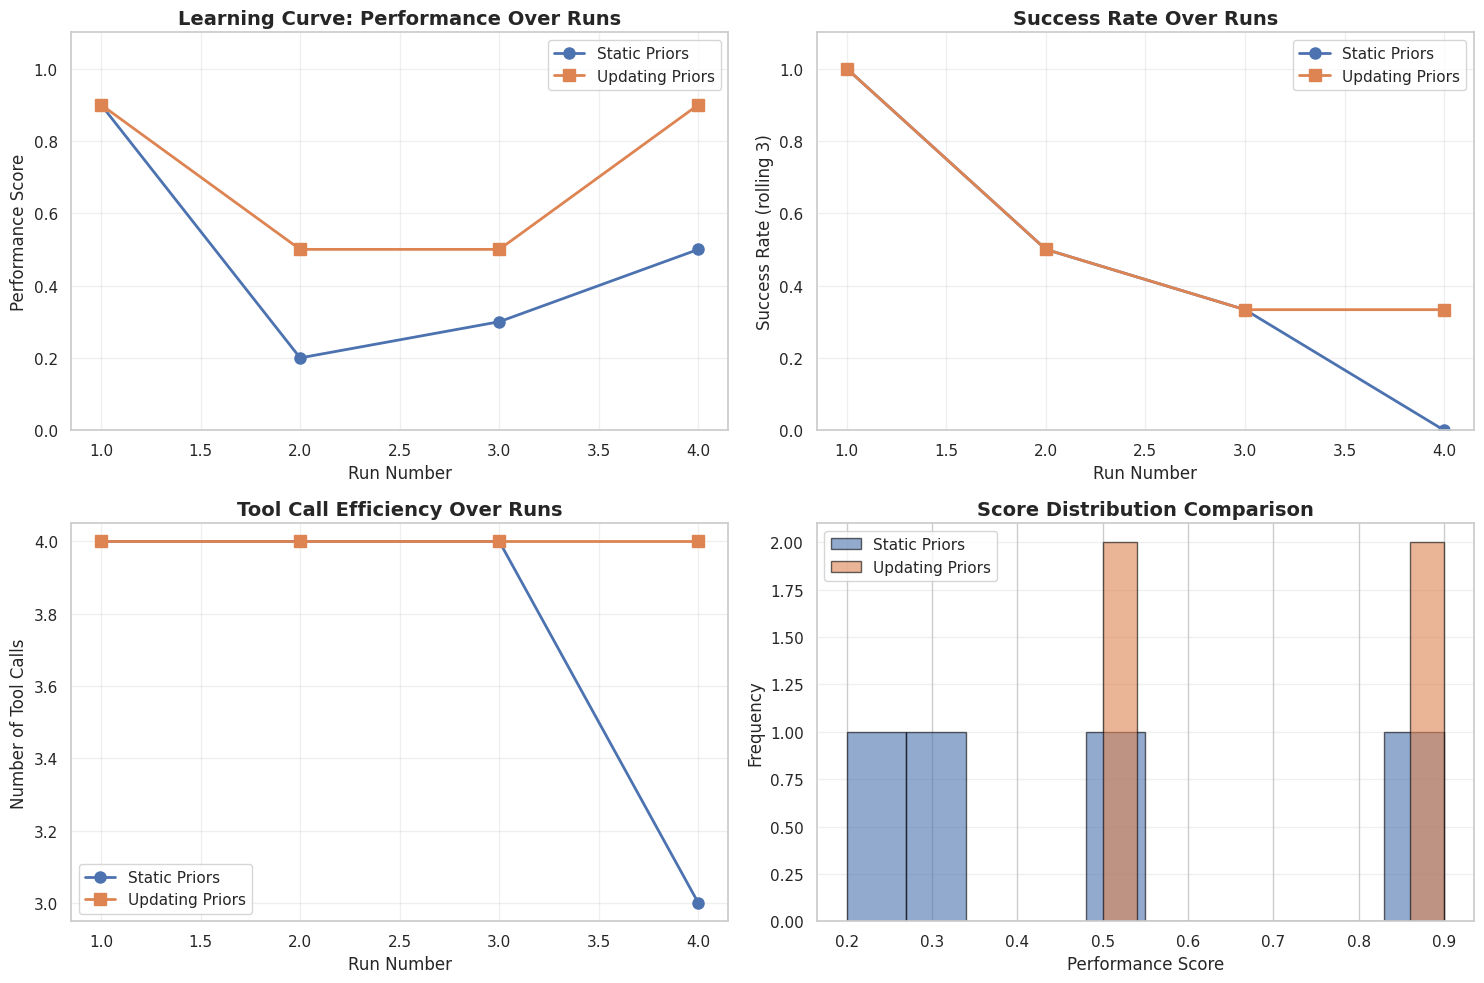


📊 Visualizations complete!


In [11]:
# Combine results and create visualizations
all_results = static_results + updating_results
df_results = pd.DataFrame(all_results)

# Visualize Learning Curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Score over runs (learning curve)
ax1 = axes[0, 0]
static_scores = df_results[df_results['condition'] == 'static']['score'].values
updating_scores = df_results[df_results['condition'] == 'updating']['score'].values
runs = np.arange(1, len(static_scores) + 1)

ax1.plot(runs, static_scores, 'o-', label='Static Priors', linewidth=2, markersize=8)
ax1.plot(runs, updating_scores, 's-', label='Updating Priors', linewidth=2, markersize=8)
ax1.set_xlabel('Run Number', fontsize=12)
ax1.set_ylabel('Performance Score', fontsize=12)
ax1.set_title('Learning Curve: Performance Over Runs', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1.1])

# 2. Success rate over runs (rolling window)
ax2 = axes[0, 1]
window = 3
static_passed = df_results[df_results['condition'] == 'static']['passed'].values
updating_passed = df_results[df_results['condition'] == 'updating']['passed'].values

static_rolling = pd.Series(static_passed).rolling(window=window, min_periods=1).mean()
updating_rolling = pd.Series(updating_passed).rolling(window=window, min_periods=1).mean()

ax2.plot(runs, static_rolling, 'o-', label='Static Priors', linewidth=2, markersize=8)
ax2.plot(runs, updating_rolling, 's-', label='Updating Priors', linewidth=2, markersize=8)
ax2.set_xlabel('Run Number', fontsize=12)
ax2.set_ylabel(f'Success Rate (rolling {window})', fontsize=12)
ax2.set_title('Success Rate Over Runs', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1.1])

# 3. Average tool calls
ax3 = axes[1, 0]
static_tools = df_results[df_results['condition'] == 'static']['num_tool_calls'].values
updating_tools = df_results[df_results['condition'] == 'updating']['num_tool_calls'].values

ax3.plot(runs, static_tools, 'o-', label='Static Priors', linewidth=2, markersize=8)
ax3.plot(runs, updating_tools, 's-', label='Updating Priors', linewidth=2, markersize=8)
ax3.set_xlabel('Run Number', fontsize=12)
ax3.set_ylabel('Number of Tool Calls', fontsize=12)
ax3.set_title('Tool Call Efficiency Over Runs', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# 4. Score distribution comparison
ax4 = axes[1, 1]
ax4.hist(static_scores, bins=10, alpha=0.6, label='Static Priors', edgecolor='black')
ax4.hist(updating_scores, bins=10, alpha=0.6, label='Updating Priors', edgecolor='black')
ax4.set_xlabel('Performance Score', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Score Distribution Comparison', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Visualizations complete!")
